# 2) Portrait segmentation with CelebA Test

In this notebook we try to adapt our Dynamic U-Net model for Potrait Segmentation on CelebFaces Attributes (CelebA) dataset.

First step would be to download and explore the [CelebA dataset](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html). 
We use the data from the Alligned and Cropped Folder because according to the README all the images are of a fixed size of (218,178) which makes our work easier

In [1]:
from fastai import *
from fastai.vision import *
from PIL import Image

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
path = Path('data/Image Matting/dataset')

In [4]:
path_test = path/'final-dataset'/'img_align_celeba'
len(path_test.ls())

202599

There are 202,599 images in the dataset !!!!!!!!. We pick up the first hundred for our exploration

In [5]:
test_f = sorted(get_image_files(path_test)[:100])

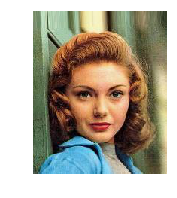

In [6]:
# Displaying an image
img = open_image(test_f[99])
img.show()

In [7]:
# Sanity Checking the image size 
img.shape

torch.Size([3, 218, 178])

Size matches whats specified in the README. Plotting some more images

In [8]:
def plot_few_potraits(img_f):
    imgf = np.random.choice(img_f,24)
    fig = plt.figure(figsize=(12,10))
    for i,f in enumerate(imgf):
        fig.add_subplot(4,6,i+1)
        plt.imshow(plt.imread(f))
        plt.axis('off')

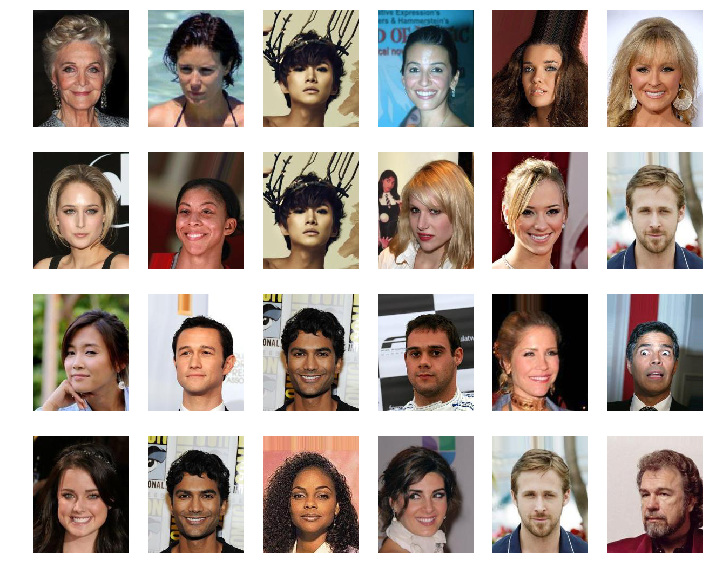

In [9]:
plot_few_potraits(test_f)

Okay the test set seems fine. We see that the Celeb Potraits take up the majority of the space in the image

Now at this stage we can continue with the data used in the previous notebook and train our models for the required size of (218,178), but while exploring the author's [website](http://xiaoyongshen.me/), it lead me to another released dataset thats around 2000 images in size along with their masks.   
Since more data almost always leads to better results we continue with the bigger dataset for the remainder of this notebook

In [10]:
path.ls()

[PosixPath('data/Image Matting/dataset/testing'),
 PosixPath('data/Image Matting/dataset/training'),
 PosixPath('data/Image Matting/dataset/final-dataset'),
 PosixPath('data/Image Matting/dataset/models')]

The 'train' and 'testing' folders are already separated. In our case the 'testing' folder is validation data

In [11]:
path_train = path/'training'

In [12]:
# Verifying no images are corrupted
#verify_images(path_train)

In [13]:
len(path_train.ls())

3400

We see below that images and their masks are present in the same folder. This explains double the size (1700*2)

In [14]:
f_train = sorted(path_train.ls())
f_train[:4]

[PosixPath('data/Image Matting/dataset/training/00001.png'),
 PosixPath('data/Image Matting/dataset/training/00001_matte.png'),
 PosixPath('data/Image Matting/dataset/training/00002.png'),
 PosixPath('data/Image Matting/dataset/training/00002_matte.png')]

Same with the Validation Set

In [15]:
path_val = path/'testing'

In [16]:
#verify_images(path_val)

In [17]:
len(path_val.ls())

600

In [18]:
f_val = sorted(path_val.ls())
f_val[:4]

[PosixPath('data/Image Matting/dataset/testing/00001.jpg'),
 PosixPath('data/Image Matting/dataset/testing/00001_matte.png'),
 PosixPath('data/Image Matting/dataset/testing/00002.png'),
 PosixPath('data/Image Matting/dataset/testing/00002_matte.png')]

The function below maps the image file names to their corresonding masks

In [19]:
get_mask_name = lambda x : f'{x.parents[0]}/{x.stem}_matte.png'

Displaying an example of an image and its mask

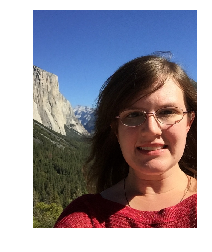

In [20]:
img = open_image(f_train[0])
img.show(figsize=(5,4))

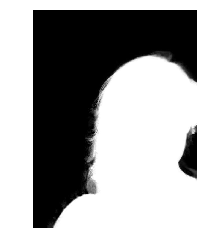

In [21]:
mask = open_mask(get_mask_name(f_train[0]))
mask.show(figsize=(5,4),div=True,alpha=1,cmap='gray')

Delving deeper into the mask data

In [22]:
mask.data

tensor([[[  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         ...,
         [  0,   0,   0,  ..., 255, 255, 255],
         [  0,   0,   0,  ..., 255, 255, 255],
         [  0,   0,   0,  ..., 255, 255, 255]]])

In [23]:
mask.data.unique()

tensor([132, 177, 158, 224, 180, 253, 255, 254, 252, 245, 251, 227, 157, 230,
        235, 243, 249, 250, 246, 247, 248, 229, 216, 155, 116, 181, 188, 206,
        223, 228, 236, 231, 233, 241, 240, 244, 242, 239, 238, 237, 234, 232,
        225, 209, 204, 195, 156, 182, 185, 192, 197, 205, 217, 218, 208, 211,
        215, 219, 222, 221, 226, 220, 214, 212, 213, 210, 203, 196, 190, 178,
        122, 126, 154, 160, 174, 176, 171, 184, 193, 191, 194, 201, 202, 200,
        199, 207, 198, 189, 186, 187, 183, 134,  95, 109, 123, 128, 159, 164,
        165, 167, 170, 169, 162, 168, 163, 166, 173, 175, 179, 172, 161, 144,
         86,  94, 100, 105,  97, 104, 113, 124, 147, 153, 151, 150, 149, 148,
        152, 146, 139, 136, 142, 145, 143, 111,  79,  90, 107, 115, 125, 135,
        138, 141, 140, 137, 133, 130, 127, 131, 129, 120, 112, 102,  99,  91,
         74,  70,  73,  75,  84, 101, 106, 110, 121, 119, 118, 117, 114, 108,
        103,  98,  96,  81,  77,  71,  68,  72,  76,  80,  85,  

We see that for this dataset, the mask data does not contain just 0 or 1 representing classes but it is a range of intensity values.  
Ideally like in the previous notebook we would like the mask to give us just two classes, hence it looks like we would have to threshold the mask data to get it down to 0 or 1 state.  
The following code deals with thresholding

We can start by dividing the mask data by 255, but the next question which arises is what value of threshold to use. The code below generates vertical strips of different thresholds to help with our decision making

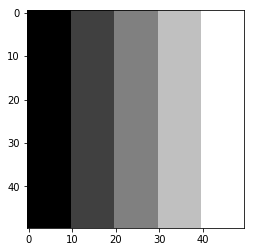

In [24]:
temp = np.zeros((50,50))
temp[:,10:20] = 0.25
temp[:,20:30] = 0.5
temp[:,30:40] = 0.75
temp[:,40:50] = 1
plt.imshow(temp,cmap='gray')

Vertical slices beyond 30 (x axis) seem like a good choice. This implies a threshold of 0.75 but using such a process would be unwise.   
A better way would be to actually try these thresholds on the data we would actually be training on. So we pick up an image from the dataset and plot it with different thresholds.

In [25]:
# Function to plot masks with different thresholds
def plot_different_thresholds(original,mask):
    original = image2np(original.data)
    mask = image2np(mask.data)/255
    fig = plt.figure(figsize=(8,8))
    fig.add_subplot(2,2,1)
    plt.imshow(original)
    plt.axis('off')
    for i,thresh in enumerate([0.25,0.5,0.75]):
        m = mask>thresh
        fig.add_subplot(2,2,i+2)
        plt.imshow(m,cmap='gray')
        plt.axis('off')
        plt.title(thresh)

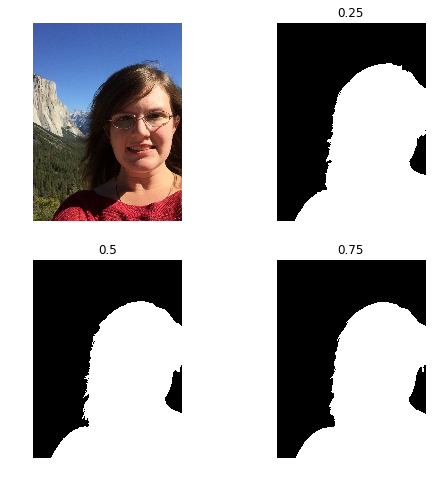

In [26]:
plot_different_thresholds(img.data,mask.data)

Although a subjective decision. I find the threshold of 0.5 to provide a perfect balance between sharpness and smoothness.  
The next step would we to threshold all the masks in the dataset.  
Inorder to prevent myself from messing up, its better to create
a new directory "final-dataset" and copy the data so I can come back if something
goes wrong 

In [27]:
path_final = path/'final-dataset'

In [28]:
path.ls()

[PosixPath('data/Image Matting/dataset/testing'),
 PosixPath('data/Image Matting/dataset/training'),
 PosixPath('data/Image Matting/dataset/final-dataset'),
 PosixPath('data/Image Matting/dataset/models')]

Using terminal commands I have duplicated the dataset into 'final-dataset' directory and renamed 'training' to 'train' and 'testing' to 'val'

In [29]:
path_final.ls()

[PosixPath('data/Image Matting/dataset/final-dataset/img_align_celeba'),
 PosixPath('data/Image Matting/dataset/final-dataset/train'),
 PosixPath('data/Image Matting/dataset/final-dataset/models'),
 PosixPath('data/Image Matting/dataset/final-dataset/val')]

In [30]:
# Getting the image file names from the train and val folders
f_train = sorted(get_image_files(path_final/'train'))
f_val = sorted(get_image_files(path_final/'val'))
# Contains both images and mask hence double the size (1700*2) and (300*2)
[len(f_train),len(f_val)]

[3400, 600]

In [31]:
##### --------  To be excecuted only once   ------------
# Function to perform thresholding on the masks
def threshold_mask(fnames):
    for f in fnames:
        if f.stem[-6:] == '_matte': # Since images and masks are in the same folder, picks up only masks
            img = Image.open(f)     # as they end in _matte.png
            temp = np.asarray(img)/255
            temp = (temp > 0.5).astype('uint8')
            img = Image.fromarray(temp)
            img.save(f)

In [32]:
###### ------      Run only once ----------
# Sending in files from the train and val folders
#threshold_mask(f_val)
#threshold_mask(f_train)

Plotting a couple examples below of images and their masks.   
Output of mask.data.unique() -> tensor [1,0] shows only 0 or 1 is present in the mask data (Sanity Check)

tensor([1, 0])


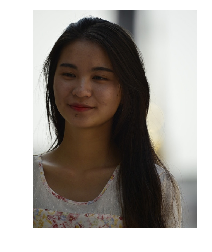

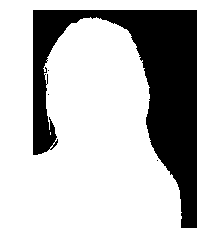

In [33]:
img = open_image(f_train[6])
img.show(figsize=(4,4))
mask = open_mask(get_mask_name(f_train[6]))
mask.show(figsize=(4,4),alpha=1,cmap='gray')
# Printing out unique elements in mask
print(mask.data.unique())

tensor([1, 0])


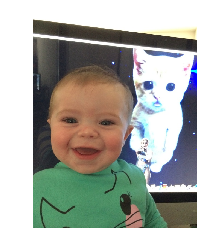

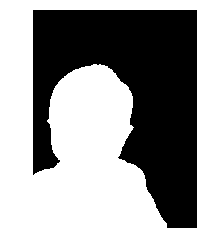

In [34]:
img = open_image(f_val[8])
img.show(figsize=(4,4))
mask = open_mask(get_mask_name(f_val[8]))
mask.show(figsize=(4,4),alpha=1,cmap='gray')
# Printing out unique elements in mask
print(mask.data.unique())

Everyting seems to be working fine let's continue.  
Now since images and masks are present in the same directory, we need a function to filter them out.  
The function below 'separate_images_from_mask' returns True if its an image and returns False if its a mask

In [35]:
# Return True if Image false if mask
def separate_images_from_mask(input):
    if input.stem[5:] == '_matte':
        return False
    return True

In [36]:
f_train[2],separate_images_from_mask(f_train[2])

(PosixPath('data/Image Matting/dataset/final-dataset/train/00002.png'), True)

In [37]:
f_train[3],separate_images_from_mask(f_train[3])

(PosixPath('data/Image Matting/dataset/final-dataset/train/00002_matte.png'),
 False)

The examples above illustrate that 'separate_images_from_mask' is functioning correctly.  
Now that we got the data in the format we need, we start training.  
I am going to use the same principles and techniques used in the previous notebook

In [38]:
# Classes 0-> represents background 1-> person
codes = ['background','person']

In [39]:
# This is so as to match our final test set (CelebA) size
size = (218,178)

In [40]:
src = (SegmentationItemList.from_folder(path_final) # Sending the parent directory,
                                                    # it will pickup files from sub-directories 'train' and 'val' 
       .filter_by_func(separate_images_from_mask)   # Since images and masks are in the same folder, need a function
                                                    # to filter them, return True for images, False for masks
       .split_by_folder(train='train', valid ='val')# How to split in train/valid? -> use folder names
       .label_from_func(get_mask_name, classes=codes))# Get labels (masks)-> get_mask_name

In [41]:
# Default transforms, normalizing using imagenet_stats
data = (src.transform(get_transforms(),size=size,tfm_y=True) 
        .databunch(bs=20)
        .normalize(imagenet_stats))

The size of the image does not match the size (CelebA) we fed in, fastai will take care of the resizing.

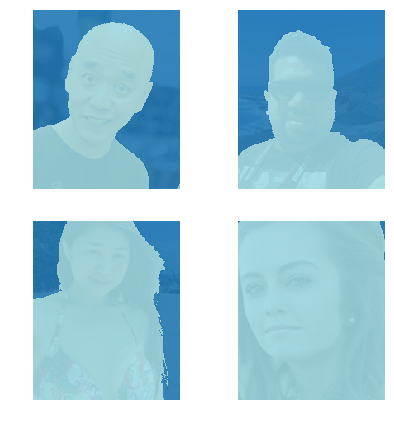

In [42]:
# Displaying a batch of masks
data.show_batch(2, figsize =(6,6),alpha=0.9)

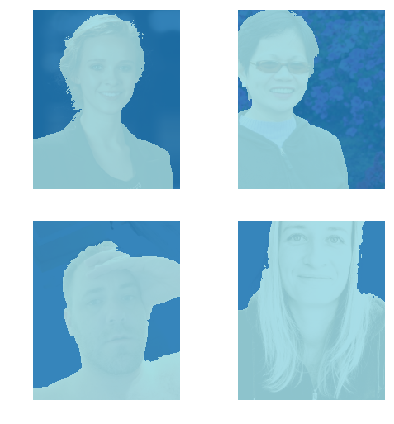

In [43]:
# Displaying a batch of masks from the validation set
data.show_batch(2, ds_type= DatasetType.Valid ,figsize =(6,6),alpha=0.9)

In [44]:
# Sanity checking number of classes and their names
data.classes,data.c

(['background', 'person'], 2)

In [45]:
# Sanity checking data object. Length seems to indicated images and masks have been separated out correctly  
[len(data.train_ds.x),len(data.valid_ds.x)]

[1700, 300]

We selected the IoU metric in the previous notebook because we wanted to compare our results with the paper.
Here can print both IoU, and pixel level classification accuracy while training and see if it leads to any differences.

In [46]:
# IoU metric
diou = partial(dice,iou=True)

In [47]:
# Defining Pixel level accuracy
def pixel_acc(input,target):
    target = target.squeeze(1)
    pred_mask = input.argmax(dim=1)
    return (target == pred_mask).float().mean()

In [48]:
learn = unet_learner(data,models.resnet34,metrics= [diou,pixel_acc])

Following the same methods as the previous notebook

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


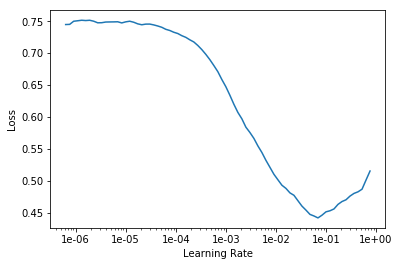

In [17]:
lr_find(learn)
learn.recorder.plot()

In [18]:
# Sharpest fall around 2e-3
lr = 2e-3

In [19]:
learn.fit_one_cycle(10, slice(lr))

epoch,train_loss,valid_loss,dice,pixel_acc
1,0.216349,0.112351,0.941019,0.959430
2,0.111337,0.084162,0.956300,0.971011
3,0.084999,0.067211,0.964526,0.976215
4,0.071183,0.057234,0.967541,0.978427
5,0.057664,0.061521,0.967185,0.978043
6,0.051429,0.059251,0.966773,0.977658
7,0.048916,0.046932,0.974313,0.982944
8,0.042221,0.046127,0.975061,0.983409
9,0.036932,0.045397,0.975329,0.983601
10,0.035011,0.044138,0.975861,0.983955


I realised that I didn't show how the learning rate varies in fit_one_cycle policy in the previous notebook.  
Hence the graph below shows how LR varies over the 10 epochs

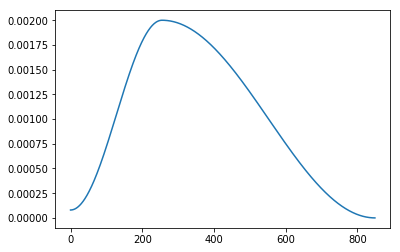

In [20]:
learn.recorder.plot_lr()

In [21]:
learn.save('stage-1')

In [22]:
learn.load('stage-1');

In [23]:
# Unfreezing and training again
learn.unfreeze()

In [24]:
lr_find(learn)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


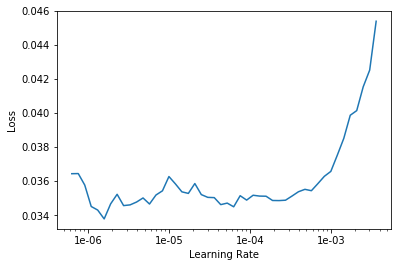

In [27]:
learn.recorder.plot(skip_end=7)

In [28]:
lrs = slice(1e-5,lr/5)

In [29]:
learn.fit_one_cycle(10,lrs)

epoch,train_loss,valid_loss,dice,pixel_acc
1,0.033391,0.045174,0.975260,0.983541
2,0.035950,0.047313,0.974459,0.982970
3,0.036501,0.048748,0.974971,0.983395
4,0.034876,0.047972,0.975704,0.983866
5,0.034346,0.044709,0.976345,0.984310
6,0.033453,0.045896,0.975542,0.983736
7,0.031333,0.044287,0.976101,0.984092
8,0.028641,0.043197,0.977145,0.984830
9,0.028445,0.042604,0.976857,0.984613
10,0.027673,0.042197,0.977165,0.984830


Wow! Getting an IoU of 97.7%, we see that pixel level accuracy is even higher(98.48%).  
We should realize that such a high accuracy is probably due to squishing of 800x600 images into size 218x178

In [30]:
learn.save('stage-2')

In [49]:
learn.load('stage-2');

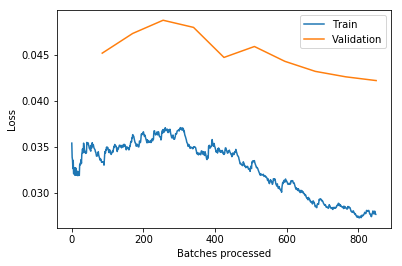

In [32]:
learn.recorder.plot_losses()

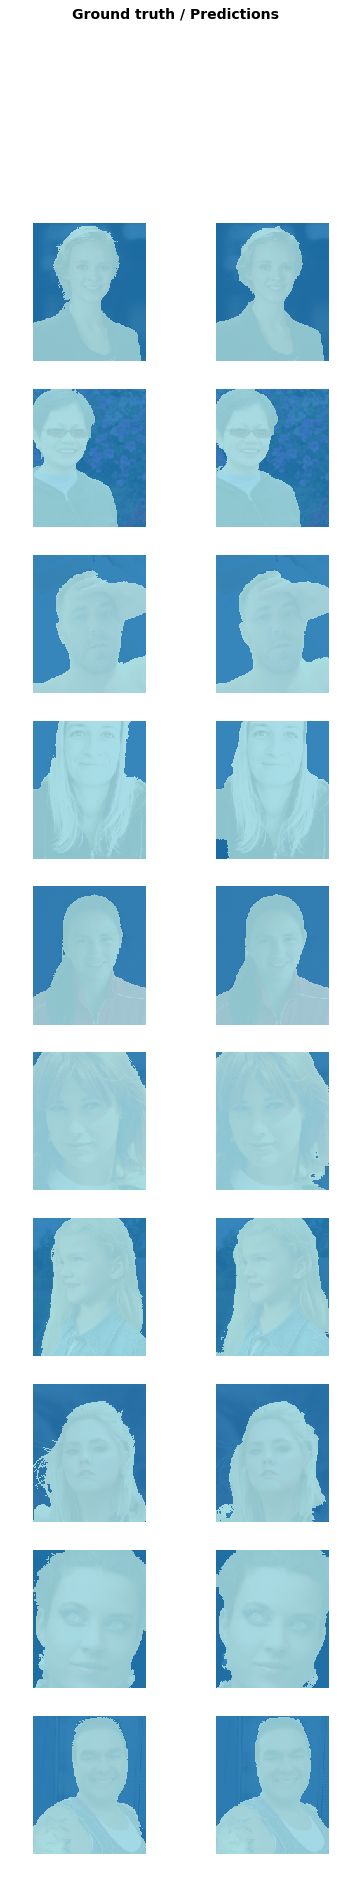

In [50]:
# Checking results on 10 images from the validation set
# Ground Truths vs Prediction masks
learn.show_results(DatasetType.Valid,rows=10,alpha=0.9)

The model is performing really well on the Validation set.  
But the real test of performance will be the CelebA dataset.  
Since the dataset has more than 200,000 images what we do is pull out 100 image from the begining, middle, end and randomly display any 10 from each set

In [51]:
# Pulls out 100 images from start, mid and end
mid = len(path_test.ls())//2
celeb_start = sorted(path_test.ls())[:100]
celeb_mid = sorted(path_test.ls())[mid:mid+100]
celeb_end = sorted(path_test.ls())[-100:]

In [52]:
# Utility function for displaying celeb faces
def plot_celeb_faces(img,i,rows,cols,fig):
    fig.add_subplot(rows,cols,i+1)
    plt.imshow(img,cmap='gray')
    plt.axis('off')
    return i+1

In [53]:
# Utility function for displaying celeb faces
def get_plot(img,i,args):
    return plot_celeb_faces(image2np(img.data),i,*args)
   

In [54]:
# Function for plotting the celeb faces
def celeb_faces(learn,fname,rows):
    random_imgs = np.random.choice(fname,rows,replace=False)
    fig = plt.figure(figsize=(12,4*rows))
    i = 0
    cols=3
    args = (rows,cols,fig)
    tab = '\t'*4
    plt.title(f"Image {tab} Prediction Mask {tab} Cutoff"
              .expandtabs(),fontsize=17)
    plt.axis('off')
    for fimg in random_imgs:
        img = open_image(fimg)
        i = get_plot(img,i,args)
        pred = learn.predict(img)
        mask = pred[0]
        i = get_plot(mask,i,args)
        final = img.data * mask.data.float()
        i = get_plot(final,i,args)

We plot the results on different parts of CelebA sets below.  
Each row contains an image randomly selected along with its prediction mask and the cutoff it created

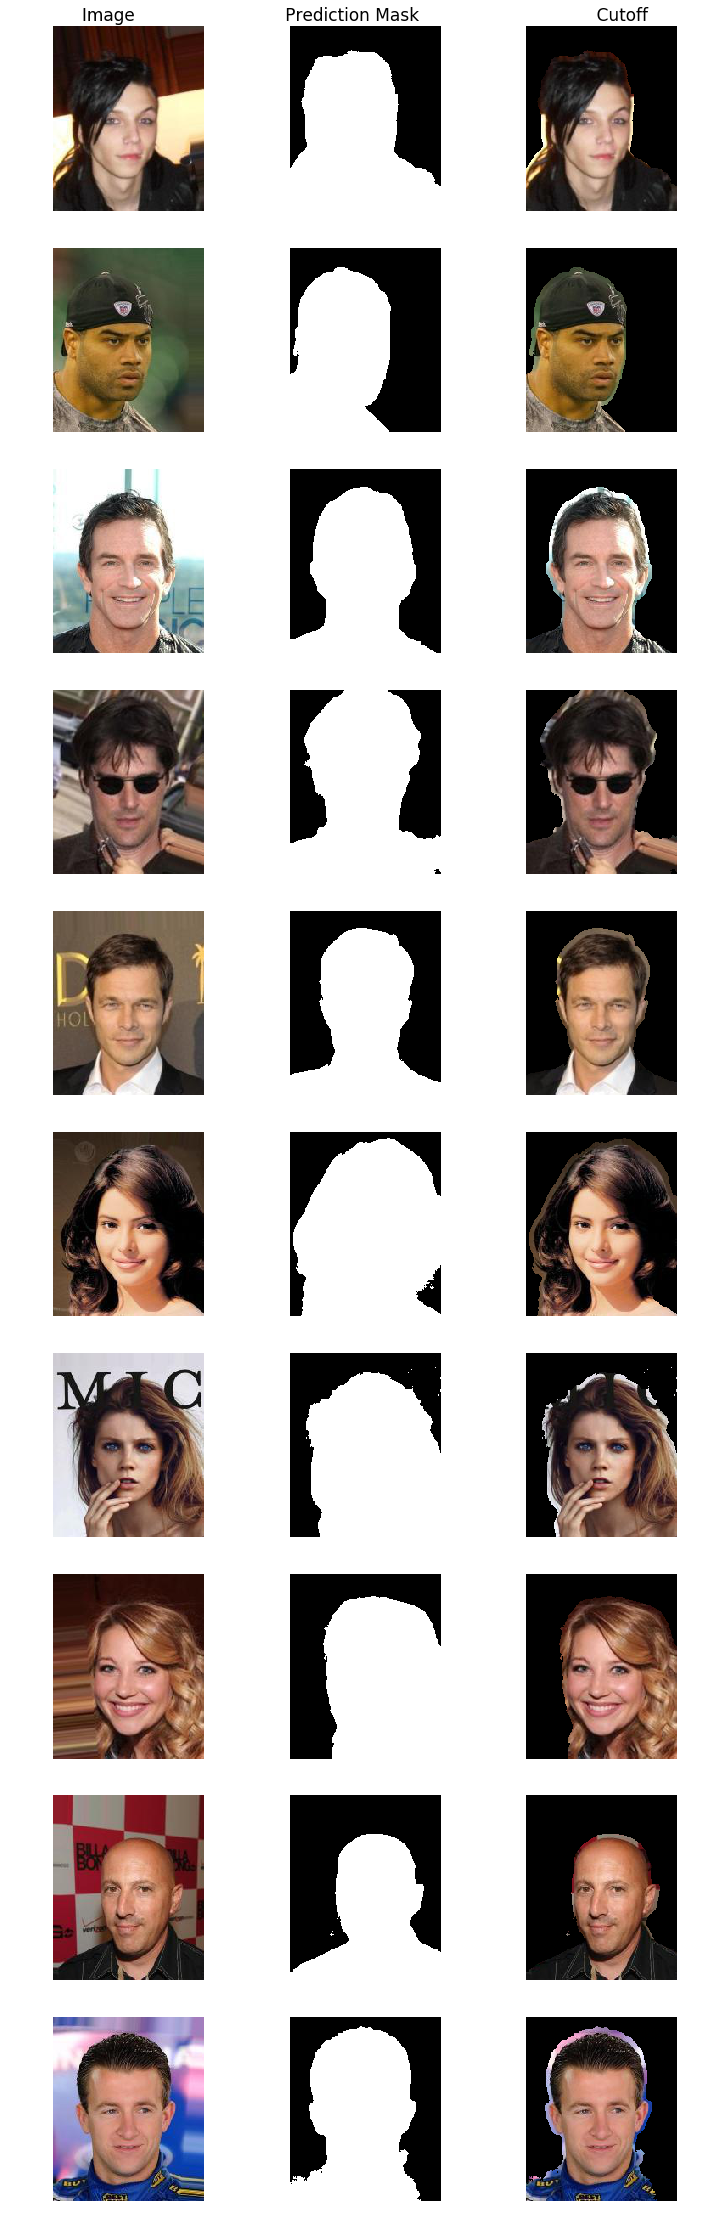

In [55]:
# Plotting random 10 images from the start
celeb_faces(learn,celeb_start,10)

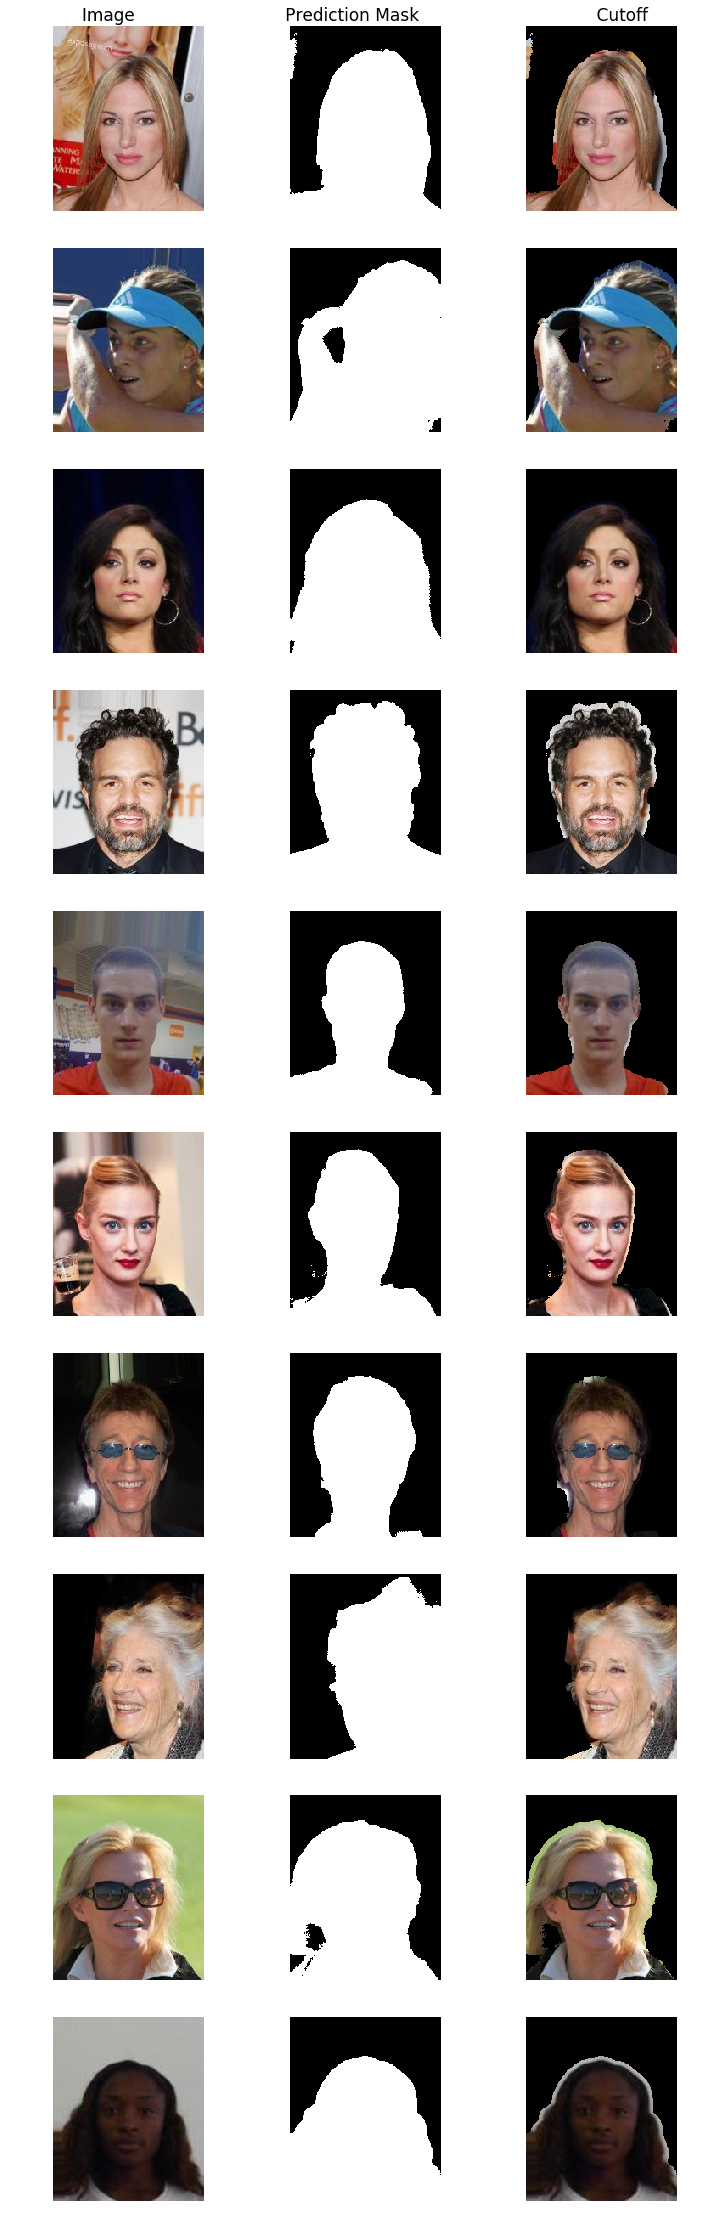

In [56]:
# Plotting random 10 images from the middle
celeb_faces(learn,celeb_mid,10)

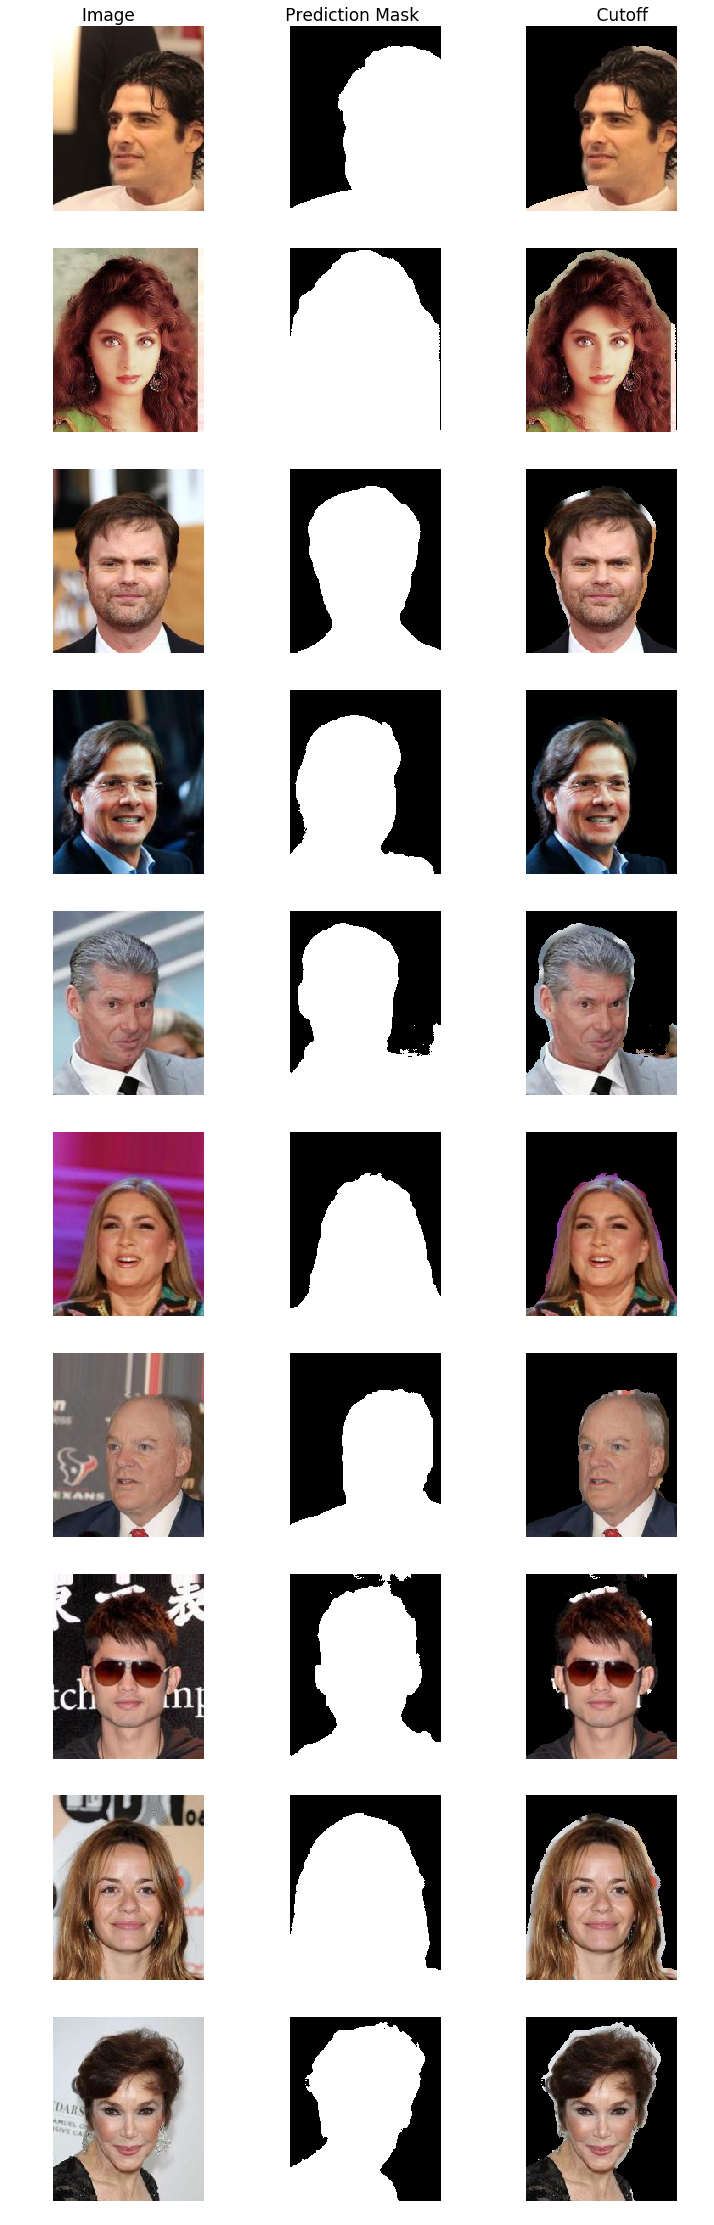

In [57]:
# Plotting random from the end
celeb_faces(learn,celeb_end,10)

The model is performing well on the CelebA dataset. It is able to follow the curves of the potrait some what reliably.    
One crtique would be that the segmentation masks generated are a little bigger in size, this is clearly visible in the cutoff images where we can spot the background artifacts.  
The reason for this (I think) is because we have taken images and masks which are almost four times the size and squished them to generate training data.

The only examples where the model suffers is when the hands of a person are in a part of the image away from their face. This is mainly because the training data doesn't have sufficient examples of this scenerio for the model to learn. Even in such cases the masks generated for the faces are reliable , it only has issues creating a mask to cover their hands  

Some ways to improve the results

* One of the most practical rules of Deep Learning is to have the validation data and the test data (i.e data we expect the model to predict on) come from the same distribution. Here since we don't have ready segmentation masks of CelebA data to compare with, we are forced to use a part of the training set as validation.   
So one way to overcome this would be to manually create segemntation masks for a potion of the celeb data and use this as a validation set. 

* In the previous notebook, we had a few cases where the mask generated would cutout some part of the foreground as well, hence another way to look at these results is that we have almost zero cases where this happens. We can now send these results to some post-processing task that can identify and clean out the narrow background artifacts.
Without the worry that it might cutout too much of the foreground. 

* In this dataset, we are actually given masks which have varying intensities, so instead of thresholding we could actually create a soft boundary by creating a person class, a background class and an unknown class.
Some post-processing task could then separate out pixels in the unknown class.

Currently I have no knowledge of what post-processing we could use. The paper seems to mention some terms like Trimaps and KNN matting, which might be worth looking into